In [19]:
%reset

Once deleted, variables cannot be recovered. Proceed (y/[n])?  y


In [20]:
import numpy as np
from scipy.sparse import csr_array, lil_array
import matplotlib.pyplot as plt
import pandas as pd
import math
import pickle
import time
import datetime
import random
from pprint import pprint

from SVD import Metrics, SVDPredictor, LogisticSVD, FastLogisticSVD
from RecData import RecData

In [21]:
# recs = pd.read_csv('data/recommendations.csv')
# recs = pd.read_csv('data/pruned.csv')
recs = pd.read_csv('data/2plus.csv')

# Remove old ratings
recs = recs.sort_values(by=['date'], ascending=False)
recs.drop_duplicates(subset= ['app_id', 'user_id'], inplace=True) 

USED_COLS = ['app_id', 'is_recommended', 'user_id']
recs = recs[USED_COLS]

item_data = pd.read_csv('data/games.csv')
titles = item_data[['app_id', 'title']]

print("Shape:", recs.shape)
recs.head()

Shape: (10267907, 3)


,app_id,is_recommended,user_id
7613972,459080,True,615114
1976676,1222140,True,6729601
4078085,860510,True,1646741
4077313,641320,False,2433891
4077199,728880,True,1803907


In [22]:
random.seed(42)
np.random.seed(42)

rec_data = RecData()
rec_data.create_from_dataframe(recs)
rec_data.set_titles(titles)

del recs

start_time = time.time()
print("Creating splits...")
train_data, test = rec_data.train_test_split(test_size=0.2)
print("First split done.")
train_data, val = train_data.train_test_split(test_size=0.2)
print("Done creating splits in", time.time() - start_time, "seconds")

Creating utility matrix...
Done utility matrix.
Creating splits...
First split done.
Done creating splits in 43.30399465560913 seconds


In [23]:
# random.seed(42)
# np.random.seed(42)

# rec_data = RecData()
# rec_data.create_from_dataframe(recs)
# rec_data.set_titles(titles)

# del recs

# print("Creating splits...")
# train_data, val, test = rec_data.leave_k_out_split(k=1)
# print("Done creating splits.")

In [24]:
del rec_data
del item_data
del titles

Epoch 0/Training error: 0.6931399664971147/Validation error: 0.6931471927563734/Time: 26.6 seconds
Epoch 1/Training error: 0.6931364796377494/Validation error: 0.6931470737959571/Time: 27.19 seconds
Epoch 2/Training error: 0.6931331517525904/Validation error: 0.693146974387466/Time: 26.8 seconds
Epoch 3/Training error: 0.6931294925205798/Validation error: 0.6931468231292943/Time: 26.88 seconds
Epoch 4/Training error: 0.693125139774812/Validation error: 0.6931465607919921/Time: 26.74 seconds
Epoch 5/Training error: 0.6931196781955109/Validation error: 0.6931460383639164/Time: 26.75 seconds
Epoch 6/Training error: 0.693112676978837/Validation error: 0.6931450617079137/Time: 26.62 seconds
Epoch 7/Training error: 0.6931031504447442/Validation error: 0.693143014068591/Time: 26.72 seconds
Epoch 8/Training error: 0.6930894955719149/Validation error: 0.6931390650936129/Time: 27.03 seconds
Epoch 9/Training error: 0.693068451608103/Validation error: 0.6931310380745365/Time: 26.89 seconds
Epoch 1

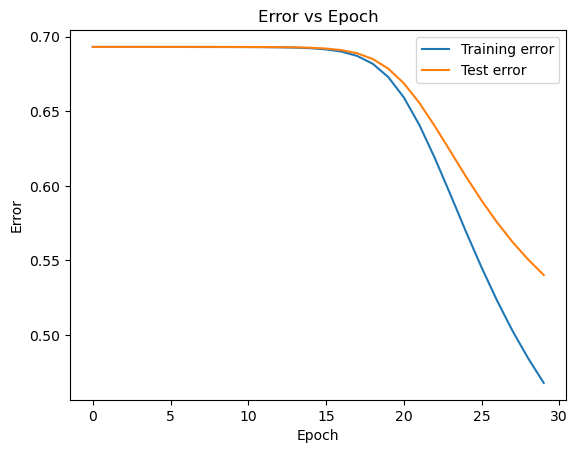

Test rmse 0.4231155401305565


In [25]:
# for pruned, epoch: 30, lr:0.01, reg:0.02

EPOCHS = 30 #240 

random.seed(42)
np.random.seed(42)

# Fit and predict with svd
svd_predictor = FastLogisticSVD(
    train_data.get_num_users(), train_data.get_num_items(), 2, k=50, 
    learning_rate=0.01, C=0.02)
svd_predictor.fit(train_data.get_matrix(), EPOCHS, validation_set=val, early_stop=False)

# Plot error
errors = svd_predictor.get_train_errors()
val_errors = svd_predictor.get_val_errors()
plt.plot(range(len(errors)), errors, label='Training error')
plt.plot(range(len(val_errors)), val_errors, label='Test error')
plt.xlabel('Epoch')
plt.ylabel('Error')
plt.title('Error vs Epoch')
plt.legend()
plt.show()

# Compute rmse
predictions = svd_predictor.predict_pairs([(user, item) for user, item, _ in val])
predictions = [prediction + (val[i][2],) for i, prediction in enumerate(predictions)]
metrics = Metrics()
rmse = metrics.rmse(predictions)
print("Test rmse", rmse)

In [30]:
svd_predictor.continue_fit(10, early_stop=False)

Epoch 0/Training error: 0.3649113275987332/Validation error: 0.48049979437117424/Time: 25.99 seconds
Epoch 1/Training error: 0.35930834401695533/Validation error: 0.47776283145943016/Time: 26.34 seconds
Epoch 2/Training error: 0.35418723614712394/Validation error: 0.4753436418017298/Time: 26.17 seconds
Epoch 3/Training error: 0.34933950703437183/Validation error: 0.4730380656928443/Time: 26.24 seconds
Epoch 4/Training error: 0.3446066484524097/Validation error: 0.4709855276799591/Time: 26.14 seconds
Epoch 5/Training error: 0.34039625957499503/Validation error: 0.4691506163302096/Time: 26.15 seconds
Epoch 6/Training error: 0.3358584877630693/Validation error: 0.46731418809258607/Time: 26.21 seconds
Epoch 7/Training error: 0.33165269794376157/Validation error: 0.46574584519353374/Time: 26.08 seconds
Epoch 8/Training error: 0.3277492026143433/Validation error: 0.4642444601854805/Time: 26.16 seconds
Epoch 9/Training error: 0.3238179689212575/Validation error: 0.4628893504387243/Time: 37.79

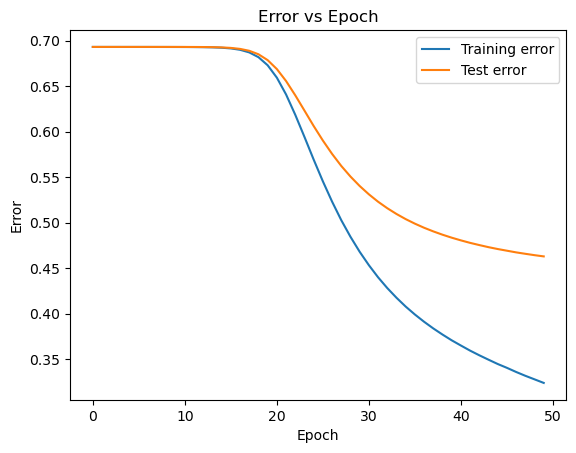

Test rmse 0.3849944608953721


In [32]:
# Plot error
errors = svd_predictor.get_train_errors()
val_errors = svd_predictor.get_val_errors()
plt.plot(range(len(errors)), errors, label='Training error')
plt.plot(range(len(val_errors)), val_errors, label='Test error')
plt.xlabel('Epoch')
plt.ylabel('Error')
plt.title('Error vs Epoch')
plt.legend()
plt.show()

# Compute rmse
predictions = svd_predictor.predict_pairs([(user, item) for user, item, _ in val])
predictions = [prediction + (val[i][2],) for i, prediction in enumerate(predictions)]
metrics = Metrics()
rmse = metrics.rmse(predictions)
print("Test rmse", rmse)

In [36]:
svd_predictor.compute_sims()

Computing similarities...
Upto row 0
Upto row 200
Upto row 400
Upto row 600
Upto row 800
Upto row 1000
Upto row 1200
Upto row 1400
Upto row 1600
Upto row 1800
Upto row 2000
Upto row 2200
Done computing similarities in 405.8188042640686 seconds


In [44]:
top = svd_predictor.items_knn([(293, 1)])
pprint([(sim, train_data.index_to_title(index)) for sim, index in top])

[(0.9934836598178022, 'Left 4 Dead 2'),
 (0.9932750433266724, 'Papers Please'),
 (0.9930878320501089, 'Counter-Strike: Source'),
 (0.9930248652087343, 'Call of Duty®: Modern Warfare® 2 (2009)'),
 (0.992819952562889, 'Wallpaper Engine'),
 (0.992537910651242, 'Terraria'),
 (0.9925366695440154, 'Portal 2'),
 (0.9925135890009634, 'Portal'),
 (0.9923979768022965, 'Euro Truck Simulator 2'),
 (0.9922682975023462, "Garry's Mod")]


In [17]:
# Ensure file exists
model_dir = model_dir = "saved_models/{}-{}-{}-{}-{}-{}_{}".format(
    *(time.localtime()[:6] + (round(rmse, 4), ))).replace(".", "-") + ".pkl" 
file = open(model_dir, 'a')
file.close()

# Save model
print("Saving model...")
with open(model_dir, 'wb') as file:
    pickle.dump([train_data, svd_predictor], file)
print("Done saving model.")

Saving model...
Done saving model.


In [35]:
j = 1

# Test top-n list for user j
top_n = svd_predictor.top_n(j, 20)
print("Predicted top n:")
pprint([(r, train_data.index_to_title(index)) for r, index in top_n])

# User j true top n list
print("True top n:")
true_top = train_data.top_n(j, 5000)
pprint([train_data.index_to_title(index) for _, index in true_top])

Predicted top n:
[(0.9206996135928255, 'Terraria'),
 (0.9184847026535525, 'Wallpaper Engine'),
 (0.9184279431494676, 'Wobbly Life'),
 (0.9181253755759784, 'BeamNG.drive'),
 (0.917575966622757, 'PowerWash Simulator'),
 (0.9174844142901013, 'CarX Drift Racing Online'),
 (0.9173332188422043, "Garry's Mod"),
 (0.9172366163661728, 'American Truck Simulator'),
 (0.9171008246042601, 'MX Bikes'),
 (0.9169435575423818, 'OMORI'),
 (0.9167840714944547, 'Clone Drone in the Danger Zone'),
 (0.916729938216813, 'ULTRAKILL'),
 (0.91655451691545, 'Bloons TD 6'),
 (0.9163327476250769, 'The Test'),
 (0.9161519525318034, 'Stray'),
 (0.9159680183399378, 'The Binding of Isaac: Rebirth'),
 (0.9159476161516685, 'PlateUp!'),
 (0.9159294076641218, 'Slay the Spire'),
 (0.9158426163539647, 'Walkabout Mini Golf VR'),
 (0.9157920999863275, 'Portal 2')]
True top n:
['Detroit: Become Human', 'Vampire Survivors', 'Borderlands 3', 'Left 4 Dead 2']


In [ ]:
# values, bins = np.histogram(svd_predictor._user_features[0, :])
# plt.stairs(values, bins)
# plt.show()

In [43]:
train_data.search_title('call')

[('Call of Duty: World at War', 387),
 ("Forest Legends: The Call of Love Collector's Edition", 1905),
 ('Call of Duty® 4: Modern Warfare®', 293),
 ('Call of Duty®: Modern Warfare® 2 (2009)', 666),
 ('Call of Duty®: WWII', 541),
 ('theHunter: Call of the Wild™', 299),
 ('Call of Duty®: Black Ops III', 478),
 ('Call of Duty®: Black Ops', 230),
 ('S.T.A.L.K.E.R.: Call of Pripyat', 1192),
 ('The Callisto Protocol™', 27),
 ('Call of Duty®: Infinite Warfare', 465),
 ('Call of Duty®: Black Ops II', 235),
 ('Call to Arms - Gates of Hell: Ostfront', 182),
 ('Call to Arms', 494),
 ('Call of Juarez: Gunslinger', 303),
 ('Call of Duty®: Modern Warfare® II', 64),
 ('Call of the Wild: The Angler™', 1001),
 ('Call of Duty®: Modern Warfare® 3', 924),
 ('Call of Duty®: Advanced Warfare - Gold Edition', 630)]

In [87]:
prefs = [(196, 0), (740, 1), (174, 1), (819, 1)]
# prefs = [(5, 1), (229, 1), (966, 0)]
pprint([(index, train_data.index_to_title(index), pref) for index, pref in prefs])
prefs = train_data.create_prefs(prefs)    

[(196, 'Mortal Kombat X', 0),
 (740, 'The Sims™ 3', 1),
 (174, 'The Sims™ 4', 1),
 (819, 'A Hat in Time', 1)]


In [ ]:
start_time = time.time()
svd_predictor.partial_fit(prefs, epochs=EPOCHS)
print("Completed partial fit in", time.time() - start_time, "seconds")

In [ ]:
top_n = svd_predictor.top_n(svd_predictor._num_users - 1, 20)
print("Predicted top n")
pprint([(r, train_data.index_to_title(index)) for r, index in top_n])